# Google Landmark Recognition
The Goal of this notebook is to find a recognize the google landmarks. There are over 200,000 landmarks to figure out
https://www.kaggle.com/c/landmark-recognition-2019

In [16]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import fastai
from fastai import *
from fastai.vision import *
import os
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback
from fastai import *
from fastai.vision import *
from fastai.vision.models.wrn import wrn_22
from fastai.metrics import accuracy_thresh, top_k_accuracy
torch.backends.cudnn.benchmark = True
from tqdm import tqdm
import pickle
import torch 
print(torch.__version__)

# A dataframe can make 
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

imgsize = 256
bs = 230# 380   # Move this up 10? Resnet50
path = "/dataslow/google/"

1.1.0


In [17]:
# Get dataframe broken down into a good subset. There are several other 

df = pd.read_csv(path+'train.csv')
#df = pd.read_csv(path+'256/t10labels.csv')
#df = pd.read_csv(path+'256/t100labels.csv')
#df = pd.read_csv(path+'256/t1000labels.csv')
#df = pd.read_csv(path+'256/t5000labels.csv')
#df = pd.read_csv(path+'256/t10000labels.csv')
#df = pd.read_csv(path+'256/t20000labels.csv')
#df = pd.read_csv(path+'256/5splitFor45594.csv')

# Anything under 22 removed
#df = pd.read_csv("/home/jd/data/google/256/under22.csv")


# drop url
del df['url']
df.head(), len(df)

(                 id  landmark_id
 0  6e158a47eb2ca3f6       142820
 1  202cd79556f30760       104169
 2  3ad87684c99c06e1        37914
 3  e7f70e9c61e66af3       102140
 4  4072182eddd0100e         2474, 4132914)

## Data Preprocess

### EDA

In [6]:
# How many unique landmarks are there?
groups=df.groupby('landmark_id')['id'].nunique()
groups.sort_values()

landmark_id
129118        1
14206         1
67855         1
114977        1
143380        1
          ...  
192931     2627
176528     3243
177870     3327
62798      4333
138982    10247
Name: id, Length: 203094, dtype: int64

### Combine sets under 22
One possible solution was to combine all images below a certain threshold to reduce the number of classes

In [ ]:
# Get the whole dataset
overalldf = pd.read_csv(path+'train.csv')
overalldf[:5]

In [ ]:
# Make a sample of everything under 22 images
under22=overalldf.groupby('landmark_id')['id'].nunique()
under22=under22.where(under22 < 22)
under22=under22.dropna(how='any')
under22=under22.index.tolist()
under22

In [ ]:
# Change them into landmark id 99999999
changed=overalldf.replace([under22],99999999)
overalldf

In [ ]:
# save this
changed.to_csv("/home/jd/data/google/256/under22.csv", encoding='utf-8',index=False)

### Top X 

In [ ]:
# Get the top X categories
lst=df.groupby('landmark_id')['id'].nunique()
lst

In [ ]:
# Get the X largest categories
categories= 20000
top=lst.nlargest(categories)
top[:5], sum(top)

In [ ]:
# Create df subset
samplelocations=list(top.index.values)
samplelocations[:5],len(samplelocations),

In [ ]:
#Receive files for subset
dfsubset=df[df['landmark_id'].isin(samplelocations)]
dfsubset[:5], len(dfsubset)

In [ ]:
#Make Top 10
#dfsubset.to_csv("/home/jd/data/google/256/t10labels.csv", encoding='utf-8',index=False)
dfsubset.to_csv("/home/jd/data/google/256/t20000labels.csv", encoding='utf-8',index=False)
dfsubset

In [ ]:
df=pd.read_csv("/home/jd/data/google/256/t20000labels.csv")

### Validation Set Creation
Setup a validation set with the number of landmarks

In [ ]:
# get all the unique groups
groups=df['landmark_id'].unique()
groups[:5], len(groups)

In [ ]:
# Create empty dataframe sets
dfvalid1=pd.DataFrame(columns=['id','landmark_id'])
dfvalid2=pd.DataFrame(columns=['id','landmark_id'])
dfvalid3=pd.DataFrame(columns=['id','landmark_id'])
dfvalid4=pd.DataFrame(columns=['id','landmark_id'])
dfvalid5=pd.DataFrame(columns=['id','landmark_id'])

In [ ]:
# go through the groups list
for x in tqdm(groups):
    dfsub=df.loc[df['landmark_id'] == x]
    valid1, valid2, valid3, valid4, valid5= np.array_split(dfsub, 5)
    dfvalid1=pd.concat([valid1, dfvalid1], ignore_index=True)
    dfvalid2=pd.concat([valid2, dfvalid2], ignore_index=True)
    dfvalid3=pd.concat([valid3, dfvalid3], ignore_index=True)
    dfvalid4=pd.concat([valid4, dfvalid4], ignore_index=True)
    dfvalid5=pd.concat([valid5, dfvalid5], ignore_index=True)

In [ ]:
dfvalid1['is_valid']=1
dfvalid2['is_valid']=2
dfvalid3['is_valid']=3
dfvalid4['is_valid']=4
dfvalid5['is_valid']=5

dflables=pd.concat([dfvalid1, dfvalid2, dfvalid3, dfvalid4, dfvalid5], ignore_index=True)
dflables.to_csv("/home/jd/data/google/256/5splitFor5000.csv", encoding='utf-8',index=False)

In [ ]:
dflables = pd.read_csv("/home/jd/data/google/256/5splitFor5000.csv")
xs=1
dflables['is_valid'] = (dflables['is_valid'] == xs).astype(int)
dflables.to_csv("/home/jd/data/google/256/5splitFor5000Split"+str(xs)+".csv", encoding='utf-8',index=False)
dflables['is_valid'].value_counts()

# Build Data and Learner

### Loss Function

In [2]:
#https://www.kaggle.com/c/landmark-recognition-2019/discussion/90752#latest-525286
# https://docs.fast.ai/callback.html

class GAP_vector(Callback):
       
    ''''
    "Wrap a `func` in a callback for metrics computation."
   
Compute Global Average Precision (aka micro AP), the metric for the
    Google Landmark Recognition competition. 
    This function takes predictions, labels and confidence scores as vectors.
    In both predictions and ground-truth, use None/np.nan for "no label".

    Args:
        pred: vector of integer-coded predictions
        conf: vector of probability or confidence scores for pred
        true: vector of integer-coded labels for ground truth

    Returns:
        GAP score
        
    Fastai Provides:
        last_output: contains the last output spitted by the model (eventually updated by a callback)
        last_loss: contains the last loss computed (eventually updated by a callback)
        last_target: contains the last target that got through the model (eventually updated by a callback)
    '''
    _order=-20
    def __init__(self):
        nlearn:Learner
        name:str='GAP_vector'
            
    def on_epoch_begin(self, **kwargs):
        # Creates empty list for predictions and targets
        self.targs, self.preds,  self.loss = LongTensor([]), Tensor([]),Tensor([])
        
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        # gets the predictions and targets for each batch

        # Indicies are assoicated with class prediction
        _, indices = torch.max(last_output, 1)
        indices = torch.as_tensor(indices, dtype=torch.float)#, device=device)
        # Finds the class with highest probability
        last_output = F.softmax(last_output, dim=1)[:,-1]
        
        # Appends the list with the predicted
        self.preds = torch.cat((self.preds, indices.cpu()))
        # Appends the list with the target
        self.targs = torch.cat((self.targs, last_target.cpu().long()))
        # Appends the list with the probability
        
        self.loss = torch.cat((self.loss, last_output.cpu()))
        # what do I do for loss?
        
    def on_epoch_end(self, last_output, last_loss, last_metrics, **kwargs):
        "Set the final result for GAP Score`."
        # Creates the dataframe
        x = pd.DataFrame({'pred': self.preds, 'conf': self.loss, 'true': self.targs})
        # sorts the values by confidence
        x.sort_values('conf', ascending=False, inplace=True, na_position='last')
        # Makes a column for the number correct. Is true if the prediction is the same as target
        x['correct'] = (x.true == x.pred).astype(int)
        # creates column for predictions
        x['prec_k'] = x.correct.cumsum() / (np.arange(len(x)) + 1)
        # gets the total score
        x['term'] = x.prec_k * x.correct
        # divides by the count of true
        gap = x.term.sum() / x.true.count()
        return add_metrics(last_metrics, gap)

In [3]:
def top_k_accuracy2(input:Tensor, targs:Tensor, k:int=10)->Rank0Tensor:
    "Computes the Top-k accuracy (target is in the top k predictions)."
    #input = input.topk(k=k, dim=-1)[1]
    input.topk(k=k, dim=-1)[0]
    targs = targs.unsqueeze(dim=-1).expand_as(input)
    input=torch.tensor(input, dtype=torch.float)
    targs=torch.tensor(targs, dtype=torch.float)#, device=device)
    return (input == targs).max(dim=-1)[0].float().mean()

### Builder Function

In [7]:
path= "/dataslow/google/256/"
workers= 18

tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.3)

data = ImageList.from_csv('/home/jd/data/google/256/',csv_name='5splitFor100Split1.csv',folder='train', suffix='.jpg').split_from_df(col='is_valid').label_from_df(cols='landmark_id').add_test_folder('test').transform(tfms, size=imgsize).databunch(bs=bs,num_workers=workers).normalize(imagenet_stats)

In [8]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.3)

data = ImageList.from_csv('/dataslow/google/256/',csv_name='5splitFor5000Split1.csv',folder='train', suffix='.jpg').split_from_df(col='is_valid').label_from_df(cols='landmark_id').transform(tfms, size=imgsize).databunch(bs=bs,num_workers=workers).normalize(imagenet_stats)

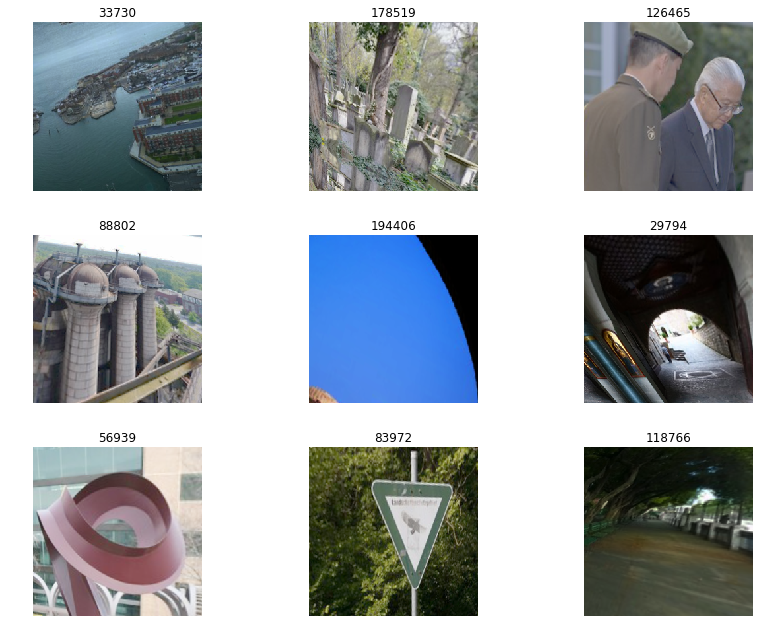

In [10]:
data.show_batch(rows=3, figsize=(12,9))

In [11]:
#arch = models.resnet34
arch =  models.resnet50

In [12]:
learn = cnn_learner(data, 
                   arch,
                    metrics=[accuracy,GAP_vector(),error_rate,top_k_accuracy]
                    ,callback_fns=[ShowGraph]
                   ).to_fp16().mixup()

In [13]:
learn.model = torch.nn.DataParallel(learn.model)

In [14]:
len(data.classes),data

(5000, ImageDataBunch;
 
 Train: LabelList (880706 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 191200,191200,191200,191200,191200
 Path: /dataslow/google/256;
 
 Valid: LabelList (222720 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 191200,191200,191200,191200,191200
 Path: /dataslow/google/256;
 
 Test: None)

In [15]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (880706 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
191200,191200,191200,191200,191200
Path: /dataslow/google/256;

Valid: LabelList (222720 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
191200,191200,191200,191200,191200
Path: /dataslow/google/256;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNo

# Start Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02


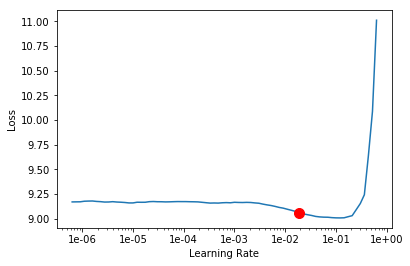

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,gap_vector,error_rate,top_k_accuracy,time
0,6.442385,4.987495,0.201136,0.029738,0.798864,0.357431,38:58
1,5.989517,4.270381,0.293027,0.062069,0.706973,0.465387,38:42
2,5.782612,3.943817,0.343175,0.086204,0.656825,0.517569,38:39


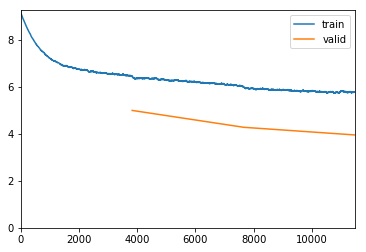

Better model found at epoch 0 with accuracy value: 0.20113594830036163.
Better model found at epoch 1 with accuracy value: 0.2930271327495575.
Better model found at epoch 2 with accuracy value: 0.3431752920150757.


In [20]:
learn.fit_one_cycle(3, max_lr=slice(1e-05,1e-02), 
                    callbacks=[EarlyStoppingCallback(learn,monitor='accuracy', min_delta=0.001, patience=1),
            SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestRes50')
           ], wd=0.001)

In [21]:
learn.load('bestRes50')

Learner(data=ImageDataBunch;

Train: LabelList (880706 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
191200,191200,191200,191200,191200
Path: /dataslow/google/256;

Valid: LabelList (222720 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
191200,191200,191200,191200,191200
Path: /dataslow/google/256;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNo

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,gap_vector,error_rate,top_k_accuracy,time
0,5.676863,3.921118,0.345797,0.087438,0.654203,0.519940,38:15
1,5.628050,3.878835,0.350171,0.089470,0.649829,0.524385,38:15
2,5.630611,3.826169,0.357323,0.092980,0.642677,0.532031,38:12
3,5.522402,3.760177,0.365459,0.097269,0.634541,0.541218,38:09
4,5.492632,3.687250,0.375310,0.102592,0.624690,0.550705,38:13
5,5.423547,3.606589,0.384555,0.107180,0.615445,0.561633,38:12
6,5.385870,3.537054,0.395187,0.113516,0.604813,0.572082,38:10
7,5.327189,3.473072,0.404364,0.119179,0.595636,0.581519,38:09
8,5.273260,3.407399,0.412168,0.123741,0.587832,0.589938,38:15
9,5.234265,3.356132,0.421448,0.129576,0.578552,0.598622,38:10


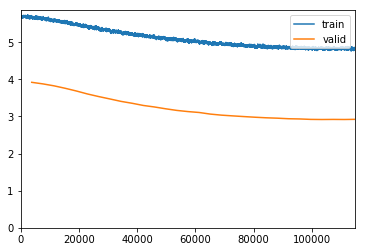

Better model found at epoch 0 with accuracy value: 0.34579741954803467.
Better model found at epoch 1 with accuracy value: 0.3501706123352051.
Better model found at epoch 2 with accuracy value: 0.3573231101036072.
Better model found at epoch 3 with accuracy value: 0.3654588758945465.
Better model found at epoch 4 with accuracy value: 0.3753097951412201.
Better model found at epoch 5 with accuracy value: 0.38455459475517273.
Better model found at epoch 6 with accuracy value: 0.39518678188323975.
Better model found at epoch 7 with accuracy value: 0.4043642282485962.
Better model found at epoch 8 with accuracy value: 0.4121677577495575.
Better model found at epoch 9 with accuracy value: 0.4214484691619873.
Better model found at epoch 10 with accuracy value: 0.42878052592277527.
Better model found at epoch 11 with accuracy value: 0.43566811084747314.
Better model found at epoch 12 with accuracy value: 0.4418642222881317.
Better model found at epoch 13 with accuracy value: 0.448114216327667

In [23]:
learn.fit_one_cycle(30, max_lr=slice(1e-06,1e-04), 
                    callbacks=[EarlyStoppingCallback(learn,monitor='accuracy', min_delta=0.001, patience=5),
            SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestRes50')
           ], wd=0.1)

In [24]:
learn.load('bestRes50')

Learner(data=ImageDataBunch;

Train: LabelList (880706 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
191200,191200,191200,191200,191200
Path: /dataslow/google/256;

Valid: LabelList (222720 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
191200,191200,191200,191200,191200
Path: /dataslow/google/256;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNo

In [25]:
savename='best-resnet50-'+str(len(data.classes))+'Final'
learn.save(savename)
print (savename)

best-resnet50-5000Final


# Save Learning

In [ ]:
#learn.load('best-34-244-1000-1') # ACC 0.400295 #GAP 0.120162
#learn.load('best-34-250-2000-1') #ACC 0.372613 #GAP 0.104532
#learn.load('best-34-250-2000-2') #ACC0.402527 #GAP 0.121679
#learn.load('best-34-250-5000-2') #ACC 0.405848  
#learn.load('best-34-250-5000-3') #ACC 0.411351 GAP 0.126338
#learn.load('best-34-250-10000-3') #ACC 0.373173 GAP 0.101827
#learn.load('best-resnet34-10000-4') #ACC 0.380324 GAP 0.106323
#learn.load('best-resnet34-45594-4')# GAPS 0.000612	0.003194
#learn.load('best-resnet34-45594-5')#0.078620	0.005124	0.026723
#learn.load('best-resnet34-45594-6')#0.124502	0.012163	0.063438
#learn.load('best-resnet34-45594-7')#0.135915	0.014391	0.075061
#learn.load('best-resnet50-45594-1')#0.024836	0.000409	
#learn.load('best-resnet50-45594-2') #0.039
#learn.load('best-resnet50-45594-3') #0.052847	0.001749
#learn.load('best-resnet50-45594-4') #0.066706	0.002737	0.014275
#learn.load('best-resnet50-20000-1') #0.295684	0.057045	0.704316
#learn.load('best-resnet50-20000-3') #6.983053	5.325345	0.287716	0.054689
#learn.load('best-resnet50-200002-1') #0.201038	0.027679	0.798962	
#learn.load('bbest-resnet50-5000Final') #0.486270	0.173539	0.513730	


# Transfer Learning

In [ ]:
# Load old weights
#learn.load('bestdog')
# Change classes to the new number of classes; there might be a more clever way; however, I know there are 37
newNumberOfClasses=20000
# Replace Linear layer output with 37
learn.model[-1][-1]=nn.Linear(in_features=512,out_features=newNumberOfClasses, bias=True)
# Save the new weights
learn.save('beststart-'+str(newNumberOfClasses))
print ('beststart-'+str(newNumberOfClasses))
# load with these nexttime

In [ ]:
learn.model = torch.nn.DataParallel(learn.model)

# Look at results

In [26]:
#Many fp16 can cause some problems
learn = learn.to_fp32()

In [27]:
# sets up the learn to look as some successful and unsuccesful images
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

TypeError: 'DataParallel' object is not subscriptable

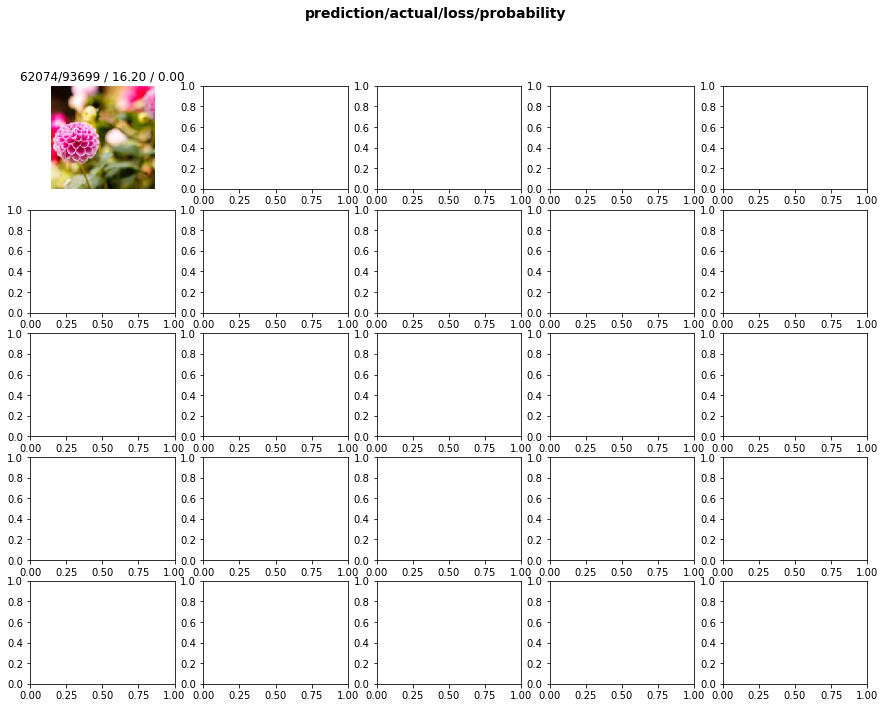

In [28]:
# What did we get wrong
interp.plot_top_losses(25, largest=True, figsize=(15,11))

In [ ]:
# just wanted to see the items we got right
interp.plot_top_losses(25, largest=False, figsize=(15,11))

In [ ]:
#interp.most_confused(min_val=2)

# Predict results

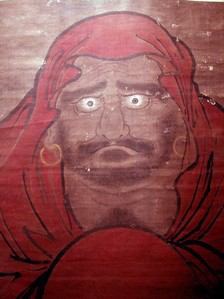

In [29]:
img = open_image('/dataslow/google/256/train/15aa768d030a3674.jpg')
#img2 = open_image('/home/jd/data/google/256/train/febe97eede304410.jpg')
#img3 = open_image('/home/jd/data/google/256/train/8536cce9c8deb3fe.jpg')
pred_class,pred_idx,outputs = learn.predict(img)
img

In [30]:
sampsub = pd.read_csv('/dataslow/google/recognition_sample_submission.csv')
sampsub.head(), len(sampsub)

(                 id landmarks
 0  cc4e1335111d0f14  8815 0.1
 1  75f7113a26d670d9  8815 0.1
 2  3eeb10b0aa3cfbff  8815 0.1
 3  cefe5f969b9d4324  8815 0.1
 4  9324ef326508dda3  8815 0.1, 117577)

In [31]:
#testlabels.head()
sampsub.head()

,id,landmarks
0,cc4e1335111d0f14,8815 0.1
1,75f7113a26d670d9,8815 0.1
2,3eeb10b0aa3cfbff,8815 0.1
3,cefe5f969b9d4324,8815 0.1
4,9324ef326508dda3,8815 0.1


# KNN

In [32]:
predictions = learn.get_preds()
pred_wv = predictions[0].numpy()

In [33]:
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=25, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=25)

In [34]:
nn_predwv = create_index(pred_wv)

In [41]:
def show_knn_img(fvec):
    idxs,dists = get_knn(nn_predwv, fvec)
    show_all([data.valid_ds[i][0] for i in idxs[:9]], 3, 3, figsize=(8, 8))
    
def show_knn_img_plus(fvec):
    idxs,dists = get_knn(nn_predwv, fvec)
    show_all([data.valid_ds[i][0] for i in idxs[:25]], 5, 5, figsize=(8, 8))
    
def show_knn_img_values(fvec):
    idxs,dists = get_knn(nn_predwv, fvec)
    val_list=[]
    for i in idxs[:25]:
        val_list.append(data.valid_ds[i][1])
    return val_list

import statistics
def knn_prediction(img):
    imgknn=learn.predict(img)
    a=show_knn_img_values(imgknn[2])
    mostCommon=statistics.mode(a)
    prob=a.count(mostCommon)/len(a)
    #print(str(mostCommon)+ " and the freq is " + str(prob))
    return mostCommon, prob;

In [42]:
knn_prediction(img)

(Category 124620, 0.96)

In [43]:
landmarks= []
landmarks2= []
probs = []

knnlandmarks= []
knnprobs = []


for x in tqdm(sampsub.id):
    try:
        img = open_image('/home/jd/data/google/256/test/'+str(x)+'.jpg')
        
        pred_class,pred_idx,outputs = learn.predict(img)
        s= outputs[pred_idx].item()
        done=(str(pred_class)+' '+str('%.4f'%s))

        
        a,b= knn_prediction(img)
        knnlandmarks.append(a)
        knnprobs.append(float(b))
        landmarks.append(done)
        probs.append(float(s))
        landmarks2.append(str(pred_class))
        
    except:
        landmarks.append(" ")
        #landmarks2.append("138982")
        landmarks2.append(" ")
        probs.append(float(0))
        knnlandmarks.append(" ")
        knnprobs.append(float(0))
        #print ("Problem with "+str(x))
        continue

100%|██████████| 117577/117577 [00:02<00:00, 41682.41it/s]


In [44]:
len(landmarks),len(landmarks2),len(probs),len(knnlandmarks),len(knnprobs),len(sampsub)

(117577, 117577, 117577, 117577, 117577, 117577)

In [45]:
len(landmarks),len(landmarks2),len(probs),len(sampsub)

(117577, 117577, 117577, 117577)

In [46]:
sampsub['landmarks']= landmarks
sampsub['probs']=probs
sampsub['landmarks2']=landmarks2
sampsub[:5]

,id,landmarks,probs,landmarks2
0,cc4e1335111d0f14,,0.0,
1,75f7113a26d670d9,,0.0,
2,3eeb10b0aa3cfbff,,0.0,
3,cefe5f969b9d4324,,0.0,
4,9324ef326508dda3,,0.0,


In [48]:
pickle.dump(sampsub, open( "/dataslow/google/256/latestsampsubUnder22.p", "wb" ) )

In [49]:
sampsub=pickle.load(open( "/dataslow/google/256/latestsampsubUnder22.p", "rb" ) )

In [50]:
sampsub

,id,landmarks,probs,landmarks2
0,cc4e1335111d0f14,,0.0,
1,75f7113a26d670d9,,0.0,
2,3eeb10b0aa3cfbff,,0.0,
3,cefe5f969b9d4324,,0.0,
4,9324ef326508dda3,,0.0,
...,...,...,...,...
117572,da80364f2008fdd5,,0.0,
117573,e9c231b5c2ec165b,,0.0,
117574,f06e50ffdc95e165,,0.0,
117575,58296f13d50f9c84,,0.0,


In [51]:
sampsub["probs"].describe()

count    117577.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: probs, dtype: float64

In [52]:
sampsub['landmarks2'].describe()

count     117577
unique         1
top             
freq      117577
Name: landmarks2, dtype: object

In [53]:
lst=sampsub.groupby('landmarks2')['id'].nunique()
#Get the 1000 largest categories
top=lst.nlargest(100)
top[:5], sum(top)

(landmarks2
      117577
 Name: id, dtype: int64, 117577)

In [54]:
sampsub.probs

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
117572    0.0
117573    0.0
117574    0.0
117575    0.0
117576    0.0
Name: probs, Length: 117577, dtype: float64

In [55]:
from decimal import Decimal
#clipping=sampsub.probs.clip(0, 1)
#sampsub['clip']=round(clipping,6)

In [56]:
# Puts the landmarks together
#sampsub["landmarks"] = sampsub["landmarks2"].map(str) + " "+ sampsub["clip"].map(str)
# We don't want the nothing 0.0 either
#sampsub["landmarks"] = sampsub["landmarks"].replace("  0.0", "")
#sampsub['clip'].max()

In [57]:
sampsub['landmarks']

0          
1          
2          
3          
4          
         ..
117572     
117573     
117574     
117575     
117576     
Name: landmarks, Length: 117577, dtype: object

In [ ]:
sampsub.to_csv('/home/jd/data/google/submissionRes34.csv', columns=['id', 'landmarks'], index=False)
print("http://localhost:8889/view/data/google/submissionRes34.csv")